In [54]:
import os
import numpy as np
import xarray as xr
import pandas as pd

import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
cartopy.config['data_dir'] = os.getenv('CARTOPY_DIR', cartopy.config.get('data_dir'))

import cmocean

import datetime as dt
from dateutil.relativedelta import *

import netCDF4
from netCDF4 import Dataset, num2date

import seaborn as sns


In [3]:
# For the bio dataset
base_url = "http://thredds.ereefs.aims.gov.au/thredds/dodsC/s3://aims-ereefs-public-prod/derived/ncaggregate/ereefs/GBR4_H2p0_B3p1_Cq3b_Dhnd/daily-monthly/EREEFS_AIMS-CSIRO_GBR4_H2p0_B3p1_Cq3b_Dhnd_bgc_daily-monthly-"

# For the hydro dataset
base_url2 = "http://thredds.ereefs.aims.gov.au/thredds/dodsC/s3://aims-ereefs-public-prod/derived/ncaggregate/ereefs/gbr4_v2/daily-monthly/EREEFS_AIMS-CSIRO_gbr4_v2_hydro_daily-monthly-"

In [4]:
month_st = 1   # Starting month 
month_ed = 1   # Ending month 
year = 2018    # Year

# Based on the server the file naming convention 
biofiles = [f"{base_url}{year}-{month:02}.nc" for month in range(month_st, month_ed+1)]
hydrofiles = [f"{base_url2}{year}-{month:02}.nc" for month in range(month_st, month_ed+1)]

Show the area that we are focusing on

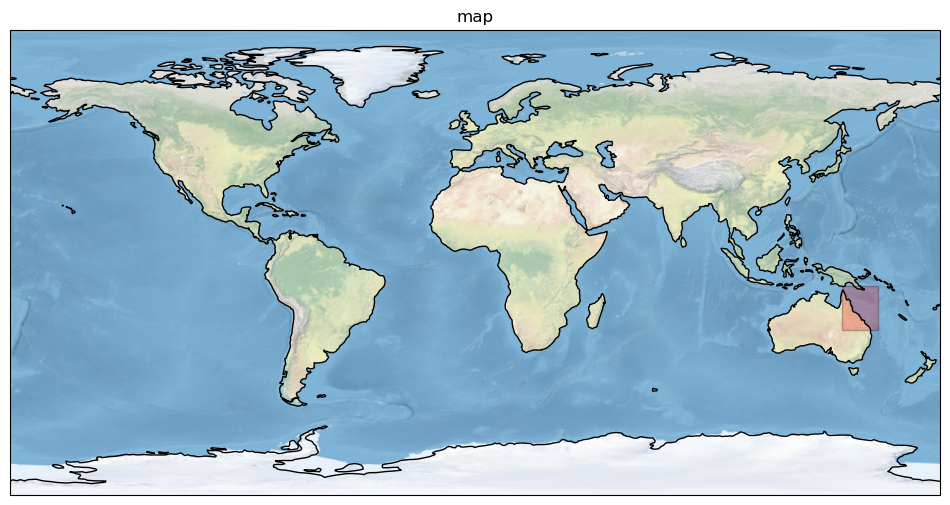

In [5]:
#extent = [np.min(ds.longitude),np.max(ds.longitude),np.min(ds.latitude),np.max(ds.latitude)]
#central_lon = np.mean(extent[:2])
#central_lat = np.mean(extent[2:])

fig0 = plt.figure(figsize=(12,12))
central_lon = 150 #TODO
ax0 = fig0.add_subplot(111,projection=ccrs.PlateCarree())
ax0.stock_img()
ax0.coastlines()
ax0.set_title('map')
ax0.add_patch(mpatches.Rectangle(xy=[142, -26], width=14, height=17, #TODO
                                    facecolor='red',
                                    edgecolor='k',
                                    alpha=0.25,
                                    transform=ccrs.PlateCarree()))
plt.show()


Heron Reefs

In [78]:
# Heron Reefs position
# TODO
min_lon = 151    # lower left longitude
min_lat = -24     # lower left latitude
max_lon = 153     # upper right longitude
max_lat = -22.35     # upper right latitude

# Defining the boundaries
lon_bnds = [min_lon, max_lon]
lat_bnds = [min_lat, max_lat]
selectedDepthIndex = -1 # corresponding to -0.5 m for GBR4

In [7]:
biofiles_timeseries = []
hydrofiles_timeseries = []

#TODO include more dates
start_date = dt.date(2015, 9, 1)
end_date = dt.date(2021, 2, 1)

current_date = start_date
while current_date <= end_date:
    year = current_date.year
    month = current_date.month
    
    # Construct the filenames for each month and year
    biofiles_timeseries.append(f"{base_url}{year}-{month:02}.nc")
    hydrofiles_timeseries.append(f"{base_url2}{year}-{month:02}.nc")
    
    # Move to the next month
    current_date += relativedelta(months=1)


In [8]:
# hydrofiles_timeseries


In [9]:
# biofiles_timeseries[50]

In [10]:

ds_hydro = xr.open_mfdataset(hydrofiles_timeseries[55:56], chunks={'time': '100MB'})

In [79]:
# Load datasets using xarray
# ds_bio = xr.open_mfdataset(biofiles_timeseries[:44], chunks={'time': '100MB'})
#TODO adjust the list to include more years
ds_hydro = xr.open_mfdataset(hydrofiles_timeseries[54:56], chunks={'time': '100MB'}) 
# Extract and select nearest values based on latitude and longitude
# alk = ds_bio.alk.sel(longitude=reef_lon, latitude=reef_lat, method='nearest')
# wind = ds_hydro.mean_wspeed.sel(longitude=reef_lon, latitude=reef_lat, method='nearest')
temperature = ds_hydro.temp.isel(k=selectedDepthIndex).sel(latitude=slice(*lat_bnds), longitude=slice(*lon_bnds)).mean(dim=['latitude', 'longitude'])
salinity = ds_hydro.salt.isel(k=selectedDepthIndex).sel(latitude=slice(*lat_bnds), longitude=slice(*lon_bnds)).mean(dim=['latitude', 'longitude'])
mean_cur = ds_hydro.mean_cur.isel(k=selectedDepthIndex).sel(latitude=slice(*lat_bnds), longitude=slice(*lon_bnds)).mean(dim=['latitude', 'longitude'])

# TODO check if wanna do rolling, show trend in line graph
# mean_cur_rolling = mean_cur.rolling(time=120, center=True).mean() # 120 days rolling window
temperature_rolling = temperature.rolling(time=10, center=True).mean()

# mean_cur_rolling_flat = mean_cur_rolling.values
# temperature_rolling_flat = temperature_rolling.values

# Create pandas dataframe from the extracted data
df = pd.DataFrame({
    'date': pd.to_datetime(temperature.time.values),
    # 'lat': temperature.latitude.values,
    # 'lon': temperature.longitude.values,
    # 'alkalinity': alk.values,
    'current': mean_cur.values,
    # 'wind': wind.values,
    'temperature': temperature.values,
    'salinity': salinity.values,
    'temperatureRolling': temperature_rolling.values
})

# Save the dataframe to a CSV file
df.to_csv("HeronReefs_timeseries_xarray.csv", sep=" ", index=False)


In [74]:
# df.head(200)

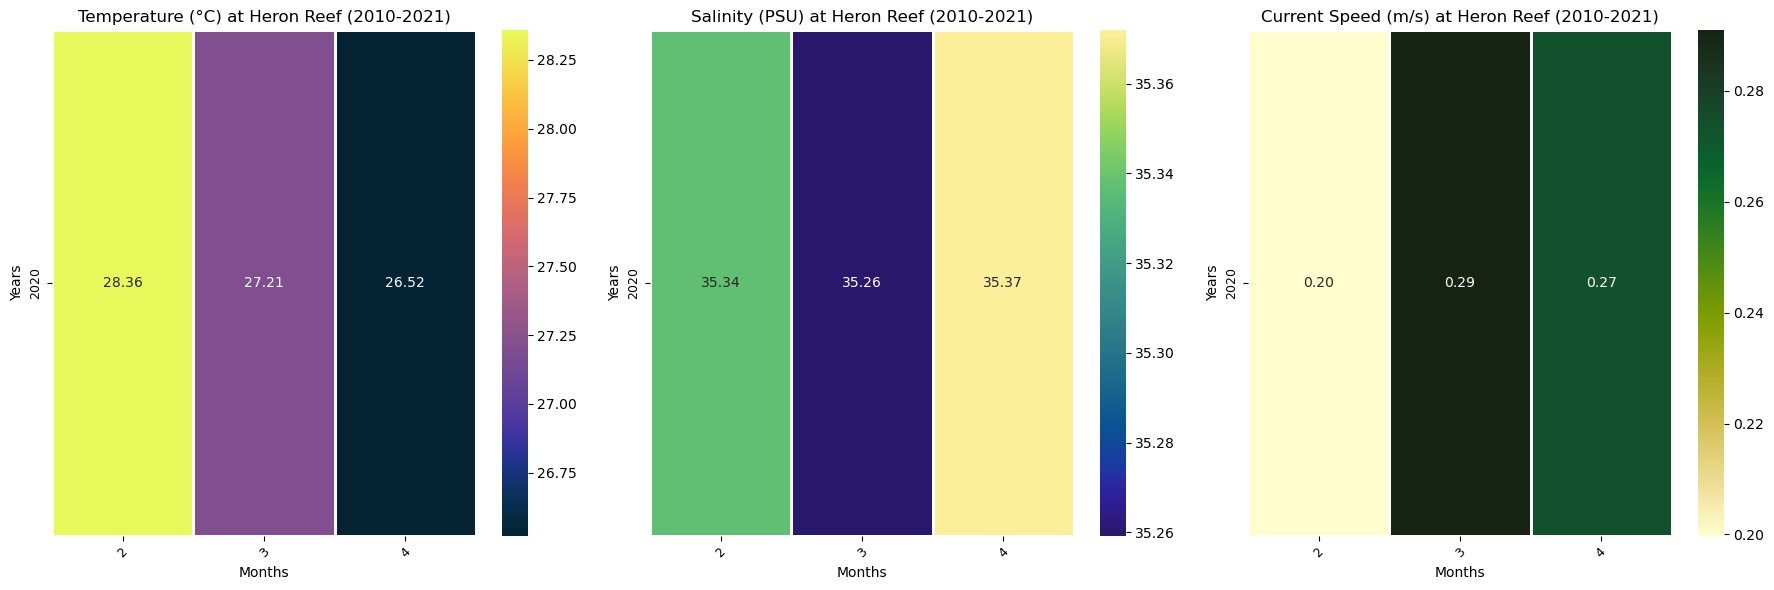

In [80]:
# Add day, month, year columns for heatmap 
df['day'] = df['date'].dt.day
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year

# Pivot the data to have months as columns and years as rows for heatmap
# Current_season = df.pivot_table(index="year", columns="month", values="current")
Temp_season = df.pivot_table(index="year", columns="month", values="temperature")
Salinity_season = df.pivot_table(index="year", columns="month", values="salinity")
Current_season = df.pivot_table(index="year", columns="month", values="current")


# Plotting Heatmaps
fig, axs = plt.subplots(1, 3, figsize=(18, 6))  # side by side

# Temperature (Degrees C)
color = cmocean.cm.thermal
sns.heatmap(
    Temp_season, annot=True, fmt=".2f", cmap=color, linewidths=1, cbar=True, ax=axs[0]
)
axs[0].set_title("Temperature (°C) at Heron Reef (2010-2021)", fontsize=12)
axs[0].set_ylabel("Years", fontsize=10)
axs[0].set_xlabel("Months", fontsize=10)
axs[0].yaxis.set_tick_params(labelsize=9)
axs[0].xaxis.set_tick_params(labelsize=9, rotation=45)

# Salinity (PSU)
color = cmocean.cm.haline
sns.heatmap(
    Salinity_season, annot=True, fmt=".2f", cmap=color, linewidths=1, cbar=True, ax=axs[1]
)
axs[1].set_title("Salinity (PSU) at Heron Reef (2010-2021)", fontsize=12)
axs[1].set_ylabel("Years", fontsize=10)
axs[1].set_xlabel("Months", fontsize=10)
axs[1].yaxis.set_tick_params(labelsize=9)
axs[1].xaxis.set_tick_params(labelsize=9, rotation=45)

# Current (Speed)
color = cmocean.cm.speed
sns.heatmap(
    Current_season, annot=True, fmt=".2f", cmap=color, linewidths=1, cbar=True, ax=axs[2]
)
axs[2].set_title("Current Speed (m/s) at Heron Reef (2010-2021)", fontsize=12)
axs[2].set_ylabel("Years", fontsize=10)
axs[2].set_xlabel("Months", fontsize=10)
axs[2].yaxis.set_tick_params(labelsize=9)
axs[2].xaxis.set_tick_params(labelsize=9, rotation=45)

# Plot
plt.tight_layout()
plt.show()

Another rolling window

In [47]:
temperature_rolling2 = temperature.rolling(time=120, center=True).mean()
df2 = pd.DataFrame({
    'date': pd.to_datetime(temperature.time.values),
    'lat': temperature.latitude.values,
    'lon': temperature.longitude.values,
    # 'alkalinity': alk.values,
    # 'current': mean_cur.values,
    # 'wind': wind.values,
    'temperature': temperature.values,
    # 'salinity': salinity.values,
    'temperatureRolling2': temperature_rolling.values
})


In [48]:
df2['temperatureRolling2']

0             NaN
1             NaN
2             NaN
3             NaN
4             NaN
          ...    
2003    29.008575
2004          NaN
2005          NaN
2006          NaN
2007          NaN
Name: temperatureRolling2, Length: 2008, dtype: float32

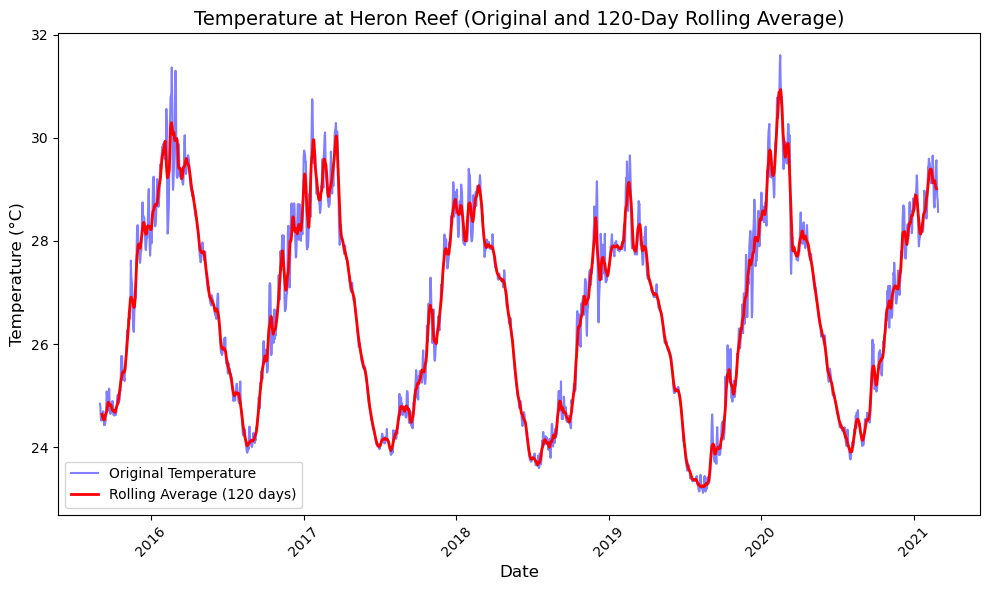

In [49]:
######################################

# Create line graph for temperature and rolling temperature

# Plotting the temperature and rolling temperature over time
fig, ax = plt.subplots(figsize=(10, 6))

# Plot original temperature data
ax.plot(df2['date'], df2['temperature'], label='Original Temperature', color='blue', alpha=0.5)

# Plot rolling average temperature data
ax.plot(df2['date'], df2['temperatureRolling2'], label='Rolling Average (120 days)', color='red', linewidth=2)

# Set title and labels
ax.set_title("Temperature at Heron Reef (Original and 120-Day Rolling Average)", fontsize=14)
ax.set_xlabel("Date", fontsize=12)
ax.set_ylabel("Temperature (°C)", fontsize=12)

# Rotate date labels for better readability
plt.xticks(rotation=45)

# Add legend to distinguish between original and rolling average
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()

In [56]:
#TODO add different reefs location
reef_lat = -23.4
reef_lon = 151.6
reef_lat1 = -23.5
reef_lon1 = 152.0

min_lon = 151    # lower left longitude
min_lat = -24     # lower left latitude
max_lon = 153     # upper right longitude
max_lat = -22.35     # upper right latitude

# Defining the boundaries
lon_bnds = [min_lon, max_lon]
lat_bnds = [min_lat, max_lat]

# Performing the reduction
# ds_bio_clip = ds_bio.sel(latitude=slice(*lat_bnds), longitude=slice(*lon_bnds))
ds_hydro_clip = ds_hydro.sel(latitude=slice(*lat_bnds), longitude=slice(*lon_bnds))

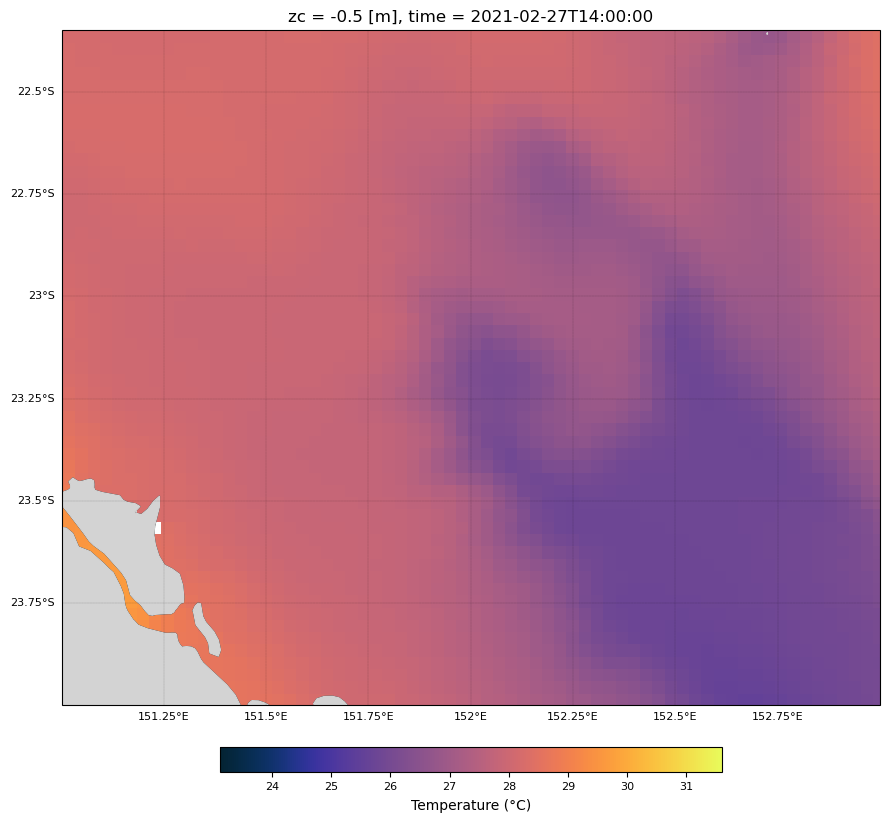

<Figure size 640x480 with 0 Axes>

In [57]:
size = (8, 8)

color = cmocean.cm.thermal

fig = plt.figure(figsize=size, facecolor='w', edgecolor='k')

ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([min_lon, max_lon, min_lat, max_lat], ccrs.PlateCarree())

ax.coastlines(resolution='10m')
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Use xarray's plot method for the temperature dataset
cf = ds_hydro_clip.temp.isel(time=-1, k=selectedDepthIndex).plot(
    ax=ax,  # assign the ax to the plot
    transform=ccrs.PlateCarree(),  # transform to PlateCarree projection
    cmap=color,  # use thermal colormap
    vmin=temperature.min().values,  # minimum value for colorbar (optional)
    vmax=temperature.max().values,  # maximum value for colorbar (optional)
    add_colorbar=False  # We'll add a colorbar separately
)

# Add colorbar to the plot
cbar = fig.colorbar(cf, ax=ax, fraction=0.027, pad=0.045, orientation="horizontal")
cbar.set_label('Temperature (°C)', rotation=0, labelpad=5, fontsize=10)
cbar.ax.tick_params(labelsize=8)

# Add gridlines and labels
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.1, color='k', alpha=1, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 8}
gl.ylabel_style = {'size': 8}

# Add land feature
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face', facecolor='lightgray'))

# Display the plot
plt.tight_layout()
plt.show()
fig.clear()
plt.close(fig)
plt.clf()